# 2015年披萨订单数据分析

In [1]:
# 导入依赖包
# %pip install -r requirements 
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import itertools
from tqdm.notebook import tqdm
from plotly.subplots import make_subplots
from pyecharts import options as opts
from pyecharts.charts import Bar, Calendar, Line, Pie, WordCloud
from pyecharts.globals import SymbolType, ThemeType
from scipy import stats

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 6)

**NOTICE:**
由于使用较多白色配色，建议在暗色主题下查看该笔记本

## 1、数据集说明

该数据集包含了某品牌一年的订单数据，总计48620条数据，大小为8.1M，包含12个字段

> 但由于统计的年份是2015年，距现在已经8年之久，在激烈竞争而日新月异的餐饮业来说，数据定然存在一定的滞后性

| 字段名            | 说明                         |
| ----------------- | ---------------------------- |
| pizza_id          | 可供订购的比萨ID               |
| order_id          | 订单ID                        |
| pizza_name_id     | 披萨名称ID                    |
| quantity          | 订单中披萨的数量               |
| order_date        | 下单日期                      |
| order_time        | 下单时间                      |
| unit_price        | 该订单的披萨单个单位成本       |
| total_price       | 该订单的披萨总成本             |
| pizza_size        | 披萨的大小：小号、中号、大号    |
| pizza_category    | 披萨的类别：素食、非素食等      |
| pizza_ingredients | 制作披萨的配料                 |
| pizza_name        | 披萨的名称                    |

In [2]:
data = pd.read_csv('pizza_sales.csv')
data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...
48617,48618.0,21348.0,napolitana_s,1.0,31-12-2015,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619.0,21349.0,mexicana_l,1.0,31-12-2015,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
48619,48620.0,21350.0,bbq_ckn_s,1.0,31-12-2015,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza


## 2、数据清洗与预处理

### 2.1 异常数据检查与处理 

In [3]:
data.isna().any().any() # 检查是否有缺失值，返回False表示没有缺失值

False

In [4]:
data.duplicated().any() # 检查是否有重复值，返回False表示没有重复值

False

In [5]:
# 可以观察到order_date有两种日期格式，需要统一格式
data['order_date'] = pd.to_datetime(data['order_date'], format='mixed')# 将order_date列转换为日期类型
data['order_time'] = pd.to_datetime(data['order_time'], format='%H:%M:%S')# 也顺便将order_time列转换为时间类型

In [6]:
# unit_price * quantity = total_price, 检查是否有不一致的数据
data[data['unit_price'] * data['quantity'] != data['total_price']].size # 返回空DataFrame，说明数据一致

0

In [7]:
# pizza_name所对应的pizza_ingrediants应该是唯一的，检查是否有不一致的数据
data.groupby('pizza_name')['pizza_ingredients'].nunique().max() # 返回1，说明数据一致

1

### 2.2 数据预处理

In [8]:
# 对pizza_name和pizza_ingredients进行strip()操作
data['pizza_name'] = data['pizza_name'].str.strip()
data['pizza_ingredients'] = data['pizza_ingredients'].str.strip()

In [9]:
# 去除不包含有效信息的pizza_id和order_id列
data.drop(columns=['pizza_id', 'order_id'], inplace=True)

In [10]:
data.sample(3)

,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
24644,veggie_veg_m,1.0,2015-01-07,1900-01-01 17:34:37,16.00,16.00,M,Veggie,"Mushrooms, Tomatoes, Red Peppers, Green Pepper...",The Vegetables + Vegetables Pizza
31847,cali_ckn_m,1.0,2015-08-22,1900-01-01 19:30:54,16.75,16.75,M,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",The California Chicken Pizza
44018,pep_msh_pep_l,1.0,2015-11-26,1900-01-01 17:21:24,17.50,17.50,L,Classic,"Pepperoni, Mushrooms, Green Peppers","The Pepperoni, Mushroom, and Peppers Pizza"


## 3、数据理解与可视化分析

### 3.1 观察pizza_size分布

In [11]:
data['pizza_size'].unique() # 查看pizza_size列的唯一值

array(['M', 'L', 'S', 'XL', 'XXL'], dtype=object)

In [12]:
data_pair =  data.groupby('pizza_size')['quantity'].sum().reset_index().values.tolist()

pie_chart = (
    Pie(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add("Pizza size", data_pair)
    .set_global_opts(title_opts=opts.TitleOpts(title="Pizza Size Distribution", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}", font_weight="bold", font_size=14, color="white"))
)
pie_chart.render_notebook()

### 3.2 观察pizza_category分布

In [13]:
data['pizza_category'].unique() 

array(['Classic', 'Veggie', 'Supreme', 'Chicken'], dtype=object)

In [14]:
value_counts = data.groupby('pizza_category')['quantity'].sum().sort_values(ascending=False)
percentages = value_counts / value_counts.sum() * 100
data_pair = list(zip(percentages.index, percentages.round(2)))

pie_chart = (
    Pie(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
    .add("Pizza Category", data_pair)
    .set_global_opts(title_opts=opts.TitleOpts(title="Pizza Category Distribution", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}%", font_weight="bold", font_size=14, color="white"))
)

pie_chart.render_notebook()

### 3.3 分析产品销量

#### 3.3.1 不同产品销量对比

In [15]:
sales_volume = data.groupby('pizza_name')[['quantity']].sum().sort_values(by='quantity', ascending=True)

data_pair = dict(zip(sales_volume.index, sales_volume['quantity']))

bar_chart = (
    Bar(init_opts=opts.InitOpts(width='1800px', height='800px', theme=ThemeType.MACARONS))
    .add_xaxis(list(data_pair.keys()))
    .add_yaxis("Sales Volume", list(data_pair.values()))
    .reversal_axis()
    .set_global_opts(title_opts=opts.TitleOpts(title="Pizza Sales Volume", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{c}", font_weight="bold", font_size=14, color="white"))
)

bar_chart.render_notebook()

#### 3.3.2 热销披萨词云

In [16]:
pizza_name_data = data[['pizza_name', 'quantity']]
pizza_name_data.loc[:, 'pizza_name'] = pizza_name_data['pizza_name'].str.split(' ').str[1:-1].str.join(' ')

pizza_name_sorted = pizza_name_data.groupby('pizza_name')['quantity'].sum().sort_values(ascending=True).to_dict()
pizza_name_sorted = [*pizza_name_sorted.items()]

word_cloud = (
    WordCloud(init_opts=opts.InitOpts(width='1800px', height='800px', theme=ThemeType.ROMANTIC))
    .add("Pizza Name",  pizza_name_sorted, word_size_range=[30, 100], shape=SymbolType.DIAMOND)
    .set_global_opts(title_opts=opts.TitleOpts(title="Pizza Sales WordCloud", title_textstyle_opts=opts.TextStyleOpts(color="Black", font_size=20, font_weight="bold")))
)

word_cloud.render_notebook()

#### 3.3.3 销售金额和日期的关系分析
> 由于数据集没有提供售价，只有提供成本，我们就大致通过成本观察销售额

In [17]:
data = data.sort_values(by='order_date')
data_pair = data.groupby('order_date')['total_price'].sum().to_list()

line_chart = (
    Line(init_opts=opts.InitOpts(width='2200px', height='600px', theme=ThemeType.MACARONS))
    .add_xaxis(list(data['order_date'].unique()))
    .add_yaxis("Sales Revenue", data_pair, is_smooth=True)
    .set_global_opts(title_opts=opts.TitleOpts(title="Sales Volume and Revenue", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
)

line_chart.render_notebook()

#### 3.3.4 销售金额与一天时间的关系分析

In [18]:
data = data.sort_values(by='order_time')
data['order_hour'] = data['order_time'].dt.hour.astype(str)
data_pair = data.groupby('order_hour')['total_price'].sum().to_list()

line_chart = (
    Line(init_opts=opts.InitOpts(width='1600px', height='600px', theme=ThemeType.LIGHT))
    .add_xaxis(list(data['order_hour'].unique()))
    .add_yaxis("Sales Volume", data_pair, is_smooth=True)
    .set_global_opts(title_opts=opts.TitleOpts(title="Sales Volume by Hour", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
)

line_chart.render_notebook()

### 3.4 不同配料在披萨制作中的占比

#### 3.4.1 观察使用率前10的配料在所有披萨中的占比情况

In [19]:
ingridients_data = data['pizza_ingredients'].str.split(',').explode().str.strip()
ingridients_data.unique()[:20]

array(['Kalamata Olives', 'Feta Cheese', 'Tomatoes', 'Garlic',
       'Beef Chuck Roast', 'Red Onions', 'Mushrooms', 'Red Peppers',
       'Green Peppers', 'Zucchini', 'Spinach', 'Genoa Salami',
       'Capocollo', 'Pepperoni', 'Asiago Cheese', 'Sliced Ham',
       'Pineapple', 'Mozzarella Cheese', 'Chicken', 'Jalapeno Peppers'],
      dtype=object)

In [20]:
counts = ingridients_data.value_counts()
total_counts = len(data)

top_counts = counts[:10]

data_pair = [(index, int(value / total_counts * 100)) for index, value in top_counts.items()]

pie_chart = (
    Pie()
    .add("", data_pair)
    .set_global_opts(title_opts=opts.TitleOpts(title="Top 10 Ingredients Counts", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}%", font_weight="bold", font_size=14, color="white"))
)

pie_chart.render_notebook() 

#### 3.4.2 不同芝士的使用占比
> 在我看来，芝士作为披萨的灵魂，在上图中却只有一款芝士上榜，当然芝士的种类丰富，我希望可以了解是不是所有披萨都放了芝士，以及不同芝士的使用占比

In [21]:
not_contains_cheese = data.query("~pizza_ingredients.str.contains('Cheese', na=False)", engine='python')
print(len(not_contains_cheese) / total_counts)
print(not_contains_cheese.sample(1)['pizza_ingredients'].values[0])

0.4959687371452077
Coarse Sicilian Salami, Tomatoes, Green Olives, Luganega Sausage, Onions, Garlic


竟然有50%的披萨没有放芝士，接着我们再来查看不同芝士使用占比

In [22]:
contains_cheese = data.query("pizza_ingredients.str.contains('Cheese', na=False)", engine='python')
cheese_data = contains_cheese['pizza_ingredients'].str.split(',').explode().str.strip()
cheese_data = cheese_data[cheese_data.str.contains('Cheese', na=False)]
counts = cheese_data.value_counts()
total_counts = len(contains_cheese)

data_pair = [(index, int(value / total_counts * 100)) for index, value in counts.items()]

pie_chart = (
    Pie()
    .add("", data_pair)
    .set_global_opts(title_opts=opts.TitleOpts(title="Cheese Counts", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}%", font_weight="bold", font_size=14, color="white"))
)

pie_chart.render_notebook() 

## 4、EDA(探索性数据分析)

### 4.1：问题：顾客在购买时购买披萨的大小是否和种类有关系
> 推测：根据我的生活经验，买veggie全素披萨的大概率会是注重身材的女生，因此买小号披萨的大概率会买veggie类的披萨，我们可以通过数据进行验证

In [23]:
categories = data['pizza_category'].unique()
size_labels = data['pizza_size'].unique()
sizes = data.groupby(['pizza_category', 'pizza_size'])['quantity'].sum()

# 创建子图，设置行数和列数为总分类数
fig = make_subplots(rows=1, cols=len(categories), subplot_titles=categories, specs=[[{'type':'domain'}]*len(categories)])

# 添加每个子图的饼状图
for i, category in enumerate(categories, start=1):
    fig.add_trace(go.Pie(labels=size_labels, values=sizes[category], name=category), row=1, col=i)

# 设置图表布局和标题
fig.update_layout(title_text="Pizza Category and Size Distribution", title_font_size=20, title_font_family="Arial", title_font_color="Black", template="ggplot2")

# 显示图表
fig.show()

结论：*结果并不符合预测，买veggie类型披萨的大部分买Medium的大小，而买Small的大小最多的是Classic种类的*

### 4.2: 问题：在哪些日子或者时间段销量较低
> 通过对销量较低的时间段进行预测，以更好的安排促销活动

#### 4.2.1： 问题：一周中哪一天销量最低

In [24]:
# 由于有些日期没有销售记录，需要填充缺失值，填充为平均值
filled_data = data.groupby('order_date')['total_price'].sum().reset_index()
filled_data = filled_data.set_index('order_date').resample('D').mean().fillna(0).reset_index()
filled_data

,order_date,total_price
0,2015-01-01,2713.85
1,2015-01-02,3189.20
2,2015-01-03,1598.55
...,...,...
362,2015-12-29,1353.25
363,2015-12-30,1337.80
364,2015-12-31,2916.00


In [25]:
filled_data['order_day_in_week'] = filled_data['order_date'].dt.day_name()
filled_data['order_day_in_week'] = pd.Categorical(filled_data['order_day_in_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
sales_volume_in_week = filled_data.groupby('order_day_in_week', observed=True)['total_price'].sum()
data_pair = dict(zip(sales_volume_in_week.index, sales_volume_in_week))

bar_chart = (
    Bar(init_opts=opts.InitOpts(width='1000px', height='500px', theme=ThemeType.ROMA))
    .add_xaxis(list(data_pair.keys()))
    .add_yaxis("Sales Revenue", list(data_pair.values()))
    .set_global_opts(title_opts=opts.TitleOpts(title="Sales Revenue in Week", title_textstyle_opts=opts.TextStyleOpts(color="white", font_size=20, font_weight="bold")))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{c}", font_weight="bold", font_size=14, color="white"))
)

bar_chart.render_notebook()

可以观察到周日销售额度最低，周五销售额度最高，接着我们再观察一下在销量高（也就是爆火）的日子在一周的分布

In [26]:
data_pair = data.groupby('order_date', observed=True)['total_price'].sum().sort_index().reset_index().values.tolist()
calendar_chart = (
    Calendar(init_opts=opts.InitOpts(width='1500px', height='300px', theme=ThemeType.VINTAGE))
    .add("", data_pair, calendar_opts=opts.CalendarOpts(range_='2015'))
    .set_global_opts(title_opts=opts.TitleOpts(title="Sales Revenue in 2015", title_textstyle_opts=opts.TextStyleOpts(color="black", font_size=20, font_weight="bold")),
                    visualmap_opts=opts.VisualMapOpts(max_=data_pair[1][1], min_=data_pair[-1][1], orient="horizontal", pos_right="center", pos_top='80%',is_piecewise=False, is_calculable=True, range_color=['#f0f0f0', '#ff4500'], textstyle_opts=opts.TextStyleOpts(color="black", font_size=12)))
)

calendar_chart.render_notebook()

也可以明显观察到，周日和周一完全没有爆火的日子，而周五常常爆火

结论：*周日作为周末假期的一天，但是周日的销售额度较低，具有很大的潜力作为提升销售额的方向，可以进行**疯狂披萨星期天**这样的活动进行促销*

## 5、数据建模与预测

### 建立模型根据配料成分和日期预测销量
> 推陈出新是餐饮业可以蓬勃发展的关键，而选择什么配料，以及在什么时间段发布什么产品也十分重要，我希望构建模型来对使用不同配料的披萨在不同时间段的销量进行预测

### 5.1 数据预处理

In [27]:
data_to_predict = data.groupby('pizza_name').agg({'quantity': 'sum', 'pizza_ingredients': 'first'}).reset_index()
data_to_predict['sales_level'] = pd.cut(data_to_predict['quantity'], bins=5, labels=['E', 'D', 'C', 'B', 'A'])
data_to_predict.sample(3)

,pizza_name,quantity,pizza_ingredients,sales_level
12,The Hawaiian Pizza,2422.0,"Sliced Ham, Pineapple, Mozzarella Cheese",A
28,The Spinach Supreme Pizza,950.0,"Spinach, Red Onions, Pepperoni, Tomatoes, Arti...",D
30,The Thai Chicken Pizza,2371.0,"Chicken, Pineapple, Tomatoes, Red Peppers, Tha...",A


In [28]:
ingredients_df = data_to_predict['pizza_ingredients'].str.get_dummies(sep=', ')
data_to_train = pd.concat([data_to_predict, ingredients_df], axis=1)
data_to_train.drop(columns=['pizza_ingredients', 'quantity'], inplace=True)
data_to_train

,pizza_name,sales_level,?duja Salami,Alfredo Sauce,Anchovies,Artichoke,Artichokes,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,Brie Carre Cheese,Calabrese Salami,Capocollo,Caramelized Onions,Chicken,Chipotle Sauce,Chorizo Sausage,Cilantro,Coarse Sicilian Salami,Corn,Eggplant,Feta Cheese,Fontina Cheese,Friggitello Peppers,Garlic,Genoa Salami,Goat Cheese,Gorgonzola Piccante Cheese,Gouda Cheese,Green Olives,Green Peppers,Italian Sausage,Jalapeno Peppers,Kalamata Olives,Luganega Sausage,Mozzarella Cheese,Mushrooms,Onions,Oregano,Pancetta,Parmigiano Reggiano Cheese,Pears,Peperoncini verdi,Pepperoni,Pesto Sauce,Pineapple,Plum Tomatoes,Prosciutto,Prosciutto di San Daniele,Provolone Cheese,Red Onions,Red Peppers,Ricotta Cheese,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini
0,The Barbecue Chicken Pizza,A,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
1,The Big Meat Pizza,B,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Brie Carre Pizza,E,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,The Spinach and Feta Pizza,C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
30,The Thai Chicken Pizza,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
31,The Vegetables + Vegetables Pizza,C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1


### 5.2 数据建模
> 由于数据量极少，不分出测试集了，主要通过图像观察数据的一些性质

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz

X = data_to_train.drop(columns=['pizza_name', 'sales_level'])
y = data_to_train['sales_level']
X.shape, y

((32, 65),
 0     A
 1     B
 2     E
      ..
 29    C
 30    A
 31    C
 Name: sales_level, Length: 32, dtype: category
 Categories (5, object): ['E' < 'D' < 'C' < 'B' < 'A'])

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=102302125)
rf_model.fit(X, y)
rf_model.score(X, y)

1.0

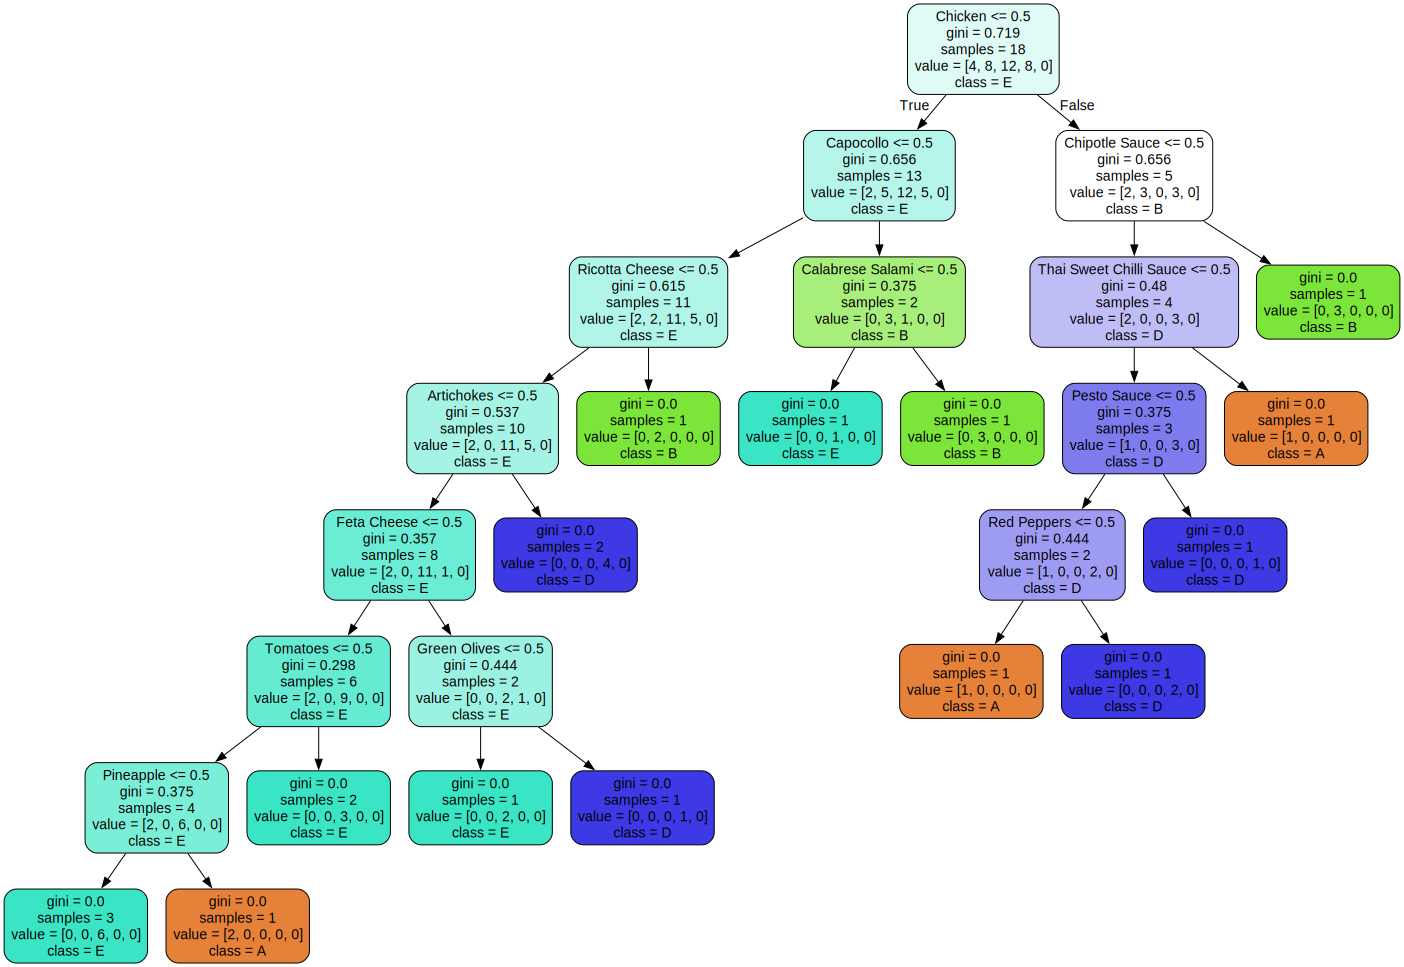

In [31]:
dot_data = tree.export_graphviz(
    rf_model.estimators_[0],
    feature_names=X.columns, # type: ignore
    class_names=y.unique(), # type: ignore
    filled=True,
    rounded=True,
)
graph = graphviz.Source(dot_data)
graph

In [32]:
feature_importance_data = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance_data = feature_importance_data.sort_values(by='importance', ascending=False)
feature_importance_data

,feature,importance
26,Garlic,0.054733
4,Artichokes,0.043005
46,Pesto Sauce,0.039030
...,...,...
61,Thai Sweet Chilli Sauce,0.004964
55,Romano Cheese,0.004918
11,Blue Cheese,0.002748


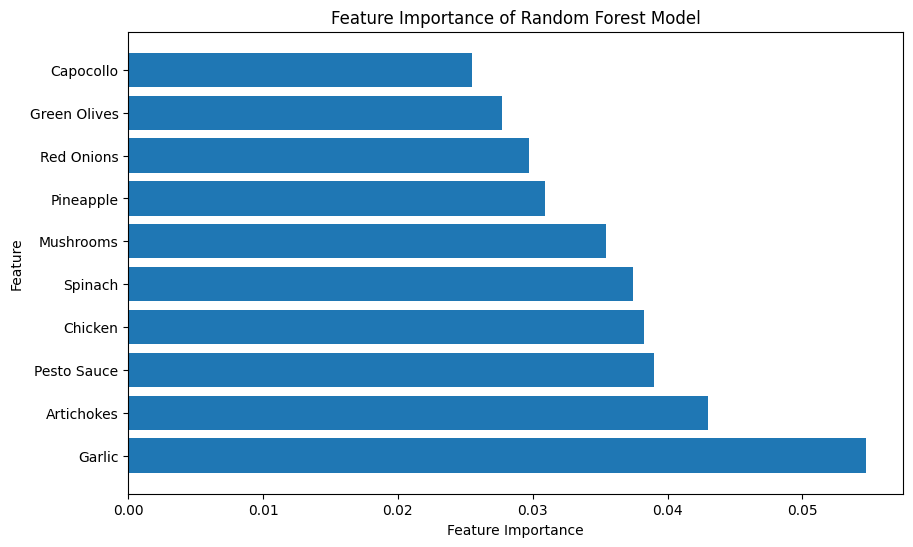

In [33]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_data['feature'][:10], feature_importance_data['importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Model')
plt.show()

### 数据预测

In [34]:
ingredients = ingredients_df.columns.to_list()
ingredients_combinations = []
most_important_ingredients = feature_importance_data['feature'][:15].to_list()

for r in range(4, 6):
    ingredients_combinations.extend(itertools.combinations(most_important_ingredients, r))

In [35]:
result_df = pd.DataFrame(columns=['Ingredients', 'Prediction'])

for combo in tqdm(ingredients_combinations):
    combo_df = pd.DataFrame([{'Ingredients': ', '.join(combo)}])
    
    combo_encoded = pd.DataFrame(0, index=range(1),columns=ingredients)
    combo_encoded.loc[0, combo] = 1    
    prediction = rf_model.predict(combo_encoded)
    
    combo_df['Prediction'] = prediction
    
    result_df = pd.concat([result_df, combo_df])
    
result_df

  0%|          | 0/4368 [00:00<?, ?it/s]

,Ingredients,Prediction
0,"Garlic, Artichokes, Pesto Sauce, Chicken",D
0,"Garlic, Artichokes, Pesto Sauce, Spinach",D
0,"Garlic, Artichokes, Pesto Sauce, Mushrooms",D
...,...,...
0,"Capocollo, Mozzarella Cheese, Pepperoni, Bacon...",A
0,"Capocollo, Tomatoes, Pepperoni, Bacon, Red Pep...",A
0,"Mozzarella Cheese, Tomatoes, Pepperoni, Bacon,...",A


In [36]:
result_df[result_df['Prediction'] == 'A']

,Ingredients,Prediction
0,"Garlic, Artichokes, Chicken, Pineapple",A
0,"Garlic, Artichokes, Pineapple, Red Onions",A
0,"Garlic, Artichokes, Pineapple, Green Olives",A
...,...,...
0,"Capocollo, Mozzarella Cheese, Pepperoni, Bacon...",A
0,"Capocollo, Tomatoes, Pepperoni, Bacon, Red Pep...",A
0,"Mozzarella Cheese, Tomatoes, Pepperoni, Bacon,...",A


> 观察到机器预测的销量为A的组合还是非常多的，由于数据量较小，定然存在一定偏差，还要结合一定的行业背景进行分析但是该模型可以辅助我们进行决策，比如说我如果打算生产这样的一款披萨：

In [37]:
combo = ['Green Olives', 'Tomatoes', 'Pepperoni', 'Mushrooms', 'Capocollo']
combo_encoded = pd.DataFrame(0, index=range(1),columns=ingredients)
combo_encoded.loc[0, combo] = 1
prediction = rf_model.predict(combo_encoded)
prediction

array(['C'], dtype=object)

> 可以观察到这个组合大概率不会有好的结果，可以考虑放弃这个想法了